In [1]:
import quantum_kan 
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import precision_score, recall_score, f1_score
from pyqubo import Binary, Array
import os
from dimod import BinaryQuadraticModel
# Solve the QUBO using a quantum annealer
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.embedding.chain_strength import uniform_torque_compensation
import time 
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from qkan import KAN
import torch.nn as nn

# Set your D-Wave API token
import os
env_vars = !cat dwave.env
for var in env_vars:
    key, value = var.split('=')
    os.environ[str(key)] = str(value)
sampler = EmbeddingComposite(DWaveSampler(solver='Advantage2_prototype2.3'))
simulated_sampler = SimulatedAnnealingSampler()

# Set the number of threads for intra-op parallelism (used for CPU operations)
torch.set_num_threads(1)

# Set the number of threads for inter-op parallelism (used for parallelism between operations)
torch.set_num_interop_threads(1)

# Verify the settings
print(f"Number of intra-op threads: {torch.get_num_threads()}")
print(f"Number of inter-op threads: {torch.get_num_interop_threads()}")

Number of intra-op threads: 1
Number of inter-op threads: 1


In [2]:
def convert_sympy_to_pyqubo(objective_func, conversion_dict):
    # Parse the simplified symbolic equation and update the QUBO matrix
    
    expression = mse_with_penalty_str
    pyqubo_expr = 0
    # Replace '-' with '+-' to simplify splitting
    expression = expression.replace(' - ', ' + -')
    # Split the expression into terms
    terms = expression.split(' + ')
    pyqubo_obj = 0

    for term in terms:
        # Split term into coefficient and variable parts
        parts = term.split('*')
        current_pyqubo_term = int(0)
        first_var = True
        for part in parts:
            if ('P' or 'AUX') in part:
                current_pyqubo_var = conversion_dict.get(part)
            else:
                current_pyqubo_var = float(part)
                
            if first_var:
                current_pyqubo_term = current_pyqubo_var
                first_var = False
            else:
                current_pyqubo_term = current_pyqubo_term * current_pyqubo_var
        # current_pyqubo_term = current_pyqubo_term * coeff
        pyqubo_obj += current_pyqubo_term
        del current_pyqubo_term
        
    return pyqubo_obj

# Define the Bernstein polynomial basis functions
def bernstein_basis_functions(x, degree):
    """
    Calculates the Bernstein polynomial basis functions.

    Args:
        x (array-like): Points at which to evaluate the basis functions.
        degree (int): Degree of the Bernstein polynomial.

    Returns:
        numpy.ndarray: A 2D array of shape (n_basis, len(x)), where each row 
                       represents a basis function evaluated at the points in x.
    """
    n = degree
    basis = np.zeros((n+1, len(x)))

    for i in range(n+1):
        binomial_coeff = math.comb(n, i)
        basis[i, :] = binomial_coeff * (x**i) * ((1 - x)**(n - i))

    return basis

def bernstein_poly(i, n, t):
    """Compute the Bernstein polynomial B_i^n at t."""
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bezier_curve(coefficients, t):
    """Compute a Bezier curve given coefficients and parameter t."""
    n = len(coefficients) - 1
    return sum(coefficients[i] * bernstein_poly(i, n, t) for i in range(n + 1))

# Normalize x_data and y_data
def normalize(data):
    data_min, data_max = data.min(), data.max()
    return (data - data_min) / (data_max - data_min)


# Define a custom base function that always returns zero
class ZeroBaseFunction(nn.Module):
    def forward(self, x):
        return torch.zeros_like(x)



In [3]:
def train_classical_optimizer(dataset, degrees, optimizer, steps, learning_rates, x_data_test, y_data_test, z_data_train, z_data_test):
    best_lr = None
    best_acc = 0


    def train_acc():
        return torch.mean((torch.round(model(dataset['train_input'])[:, 0]) == dataset['train_label'][:, 0]).float())

    def test_acc():
        return torch.mean((torch.round(model(dataset['test_input'])[:, 0]) == dataset['test_label'][:, 0]).float())


    for lr in learning_rates:
        model = KAN(width=[2, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()
        start = time.perf_counter()
        results = model.train(dataset, opt=optimizer, steps=steps, log=10, lr=lr, metrics=(train_acc, test_acc))
        end = time.perf_counter()
        print(f"Training time in seconds of lr={lr}: {end - start}")  # will print the elapsed time in seconds

        if results['test_acc'][-1] > best_acc:
            best_acc = results['test_acc'][-1]
            best_lr = lr
        print(f"Learning Rate: {lr}, Train Accuracy: {results['train_acc'][-1]}, Test Accuracy: {results['test_acc'][-1]}")

    print(f"Best Learning Rate: {best_lr} with Test Accuracy: {best_acc}")

    # Plot the results using the best learning rate
    model = KAN(width=[2, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()
    start = time.perf_counter()
    results = model.train(dataset, opt=optimizer, steps=int(steps), log=10, lr=best_lr, metrics=(train_acc, test_acc))
    end = time.perf_counter()
    time_best_lr = end - start
    print(f"Training time in seconds of best lr which is lr={lr}: {time_best_lr}")  # will print the elapsed time in seconds
    print(f"Best Learning Rate: {best_lr}, Train Accuracy: {results['train_acc'][-1]}, Test Accuracy: {results['test_acc'][-1]}")

    # Print final Bezier coefficients for each layer
    for layer_idx, layer in enumerate(model.act_fun):
        print(f"Layer {layer_idx} Bezier coefficients:")
        print(layer.coef.data.cpu().numpy())

    # Generate predictions
    with torch.no_grad():
        predictions = model(dataset['test_input']).numpy().flatten()
        thresholded_predictions = np.where(predictions > 0.5, 1, 0)

    plt.scatter(x_data_test[thresholded_predictions == 0], y_data_test[thresholded_predictions == 0], label='Class 0', c='blue', alpha=0.6)
    plt.scatter(x_data_test[thresholded_predictions == 1], y_data_test[thresholded_predictions == 1], label='Class 1', c='orange', alpha=0.6)
    # Add legend to the plot
    plt.legend()
    plt.xlabel('Normalized X Data')
    plt.ylabel('Normalized Y Data')
    plt.title('Scatter Plot with Predicted Values from KAN Model using the Adam Optimizer')
    plt.show()

    model.plot()

    # Generate predictions
    with torch.no_grad():
        predictions = model(dataset['train_input']).numpy().flatten()
        thresholded_predictions = np.where(predictions > 0.5, 1, 0)

    # Calculate precision, recall, and F1 scores
    train_accuracy = torch.mean((torch.tensor(thresholded_predictions) == z_data_train).float())
    train_precision = precision_score(dataset['train_label'].numpy(), thresholded_predictions)
    train_recall = recall_score(dataset['train_label'].numpy(), thresholded_predictions)
    train_f1 = f1_score(dataset['train_label'].numpy(), thresholded_predictions)

    # Generate predictions
    with torch.no_grad():
        predictions = model(dataset['test_input']).numpy().flatten()
        thresholded_predictions = np.where(predictions > 0.5, 1, 0)

    # Calculate precision, recall, and F1 scores
    test_accuracy = torch.mean((torch.tensor(thresholded_predictions) == z_data_test).float())
    test_precision = precision_score(dataset['test_label'].numpy(), thresholded_predictions)
    test_recall = recall_score(dataset['test_label'].numpy(), thresholded_predictions)
    test_f1 = f1_score(dataset['test_label'].numpy(), thresholded_predictions)
    print(f"time_best_lr: {time_best_lr}, train_f1: {train_f1}, test_f1: {test_f1}")
    
    return time_best_lr, train_accuracy, train_precision, train_recall, train_f1, test_accuracy, test_precision, test_recall, test_f1

In [4]:
def run_annealing(type, sampler, problem, chain_strength, time_part1, num_basis_funcs_1, num_basis_funcs_2, m1, m2, degree1, degree2, x_data_train, y_data_train, z_data_train, x_data_test, y_data_test, z_data_test, dataset, num_reads=1000, annealing_time=20):
    #Check if simulated annealer, hybrid simulated annealer, or simulated annealer
    if type == "QA":
        response = sampler.sample(problem, num_reads=num_reads, chain_strength=chain_strength, annealing_time=annealing_time)
        # Extract and print timing information
        timing_info = response.info['timing']

        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the simulated processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        time_part2 = qpu_access_time * (10**(-6))
        print(f"Time spent on simulated annealer part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "HQA":
        response = sampler.sample(problem)
        # Extract and print timing information
        timing_info = response.info

        # Print timing information
        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the quantum processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        dwave_run_time = timing_info.get('run_time', 'N/A')
        print(f"\nTotal D-Wave Run Time Including Setup: {dwave_run_time} microseconds")

        time_part2 = dwave_run_time * (10**(-6))
        print(f"Time spent on hybrid part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "SA":
        # Simulated annealing doesnt converge to a good solution as fast so generally takes more reads
        start_time_part2 = time.perf_counter()
        response = sampler.sample_qubo(problem, num_reads=num_reads)
        end_time_part2 = time.perf_counter()
        time_part2 = end_time_part2 - start_time_part2
        print(f"Time spent on simulated part 2: {time_part2}")  # will print the elapsed time in seconds
    
    # Start part 3
    start_time_part3 = time.perf_counter()
    solution = response.first.sample
    # Extract optimized coefficients
    optimized_coefficients_1 = []
    for i in range(num_basis_funcs_1):
        coeff_value_1 = sum(2**l * solution[f'coeff_plus_1[{i}][{l + m1}]'] - 2**l * solution[f'coeff_minus_1[{i}][{l + m1}]'] for l in range(-m1, m1 + 1))
        optimized_coefficients_1.append(coeff_value_1)
        
    optimized_coefficients_2 = []
    for i in range(num_basis_funcs_2):
        coeff_value_2 = sum(2**l * solution[f'coeff_plus_2[{i}][{l + m2}]'] - 2**l * solution[f'coeff_minus_2[{i}][{l + m2}]'] for l in range(-m2, m2 + 1))
        optimized_coefficients_2.append(coeff_value_2)
        
    end_time_part3 = time.perf_counter()

    time_part3 = end_time_part3 - start_time_part3
    print(f"Time spent on part 3: {time_part3}")  # will print the elapsed time in seconds

    total_time_optimization = time_part1 + time_part2 + time_part3
    print(f"Time spent on optimization: {total_time_optimization}")  # will print the elapsed time in seconds

    # Calculate Bernstein polynomial values on a fine grid
    num_fine_grids = 1000
    x_fine = np.linspace(0, 1, num_fine_grids)
    basis_functions_fine1 = bernstein_basis_functions(x_fine / 1.0, degree1)  # Normalize x to [0, 1]
    spline_values1 = np.zeros_like(x_fine)

    for i in range(num_basis_funcs_1):
        spline_values1 += optimized_coefficients_1[i] * basis_functions_fine1[i]
        
    # Plot the original data points and the fitted Bernstein polynomial spline
    plt.plot(x_fine, spline_values1, label='Fitted Bernstein polynomial spline1')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Quantum Optimized Bernstein Polynomial Spline Fit of Bezier 1')
    plt.show()

    # Calculate Bernstein polynomial values on a fine grid
    basis_functions_fine2 = bernstein_basis_functions(x_fine / 1.0, degree2)  # Normalize x to [0, 1]
    spline_values2 = np.zeros_like(x_fine)

    for i in range(num_basis_funcs_2):
        spline_values2 += optimized_coefficients_2[i] * basis_functions_fine2[i]
        
    # Plot the original data points and the fitted Bernstein polynomial spline
    plt.plot(x_fine, spline_values2, label='Fitted Bernstein polynomial spline2')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Quantum Optimized Bernstein Polynomial Spline Fit of Bezier 2')
    plt.show()

    # Calculate the bezier curve values
    bezier_result = bezier_curve(optimized_coefficients_1, x_data_test) + bezier_curve(optimized_coefficients_2, y_data_test)
    thresholded_bezier_result = np.where(bezier_result > 0.5, 1, 0)

    # Plot the data points with different colors for each label
    plt.scatter(x_data_test[thresholded_bezier_result == 0], y_data_test[thresholded_bezier_result == 0], label='Class 0', c='blue', alpha=0.6)
    plt.scatter(x_data_test[thresholded_bezier_result == 1], y_data_test[thresholded_bezier_result == 1], label='Class 1', c='orange', alpha=0.6)

    # Add legend to the plot
    plt.legend()

    # Show the plot
    plt.xlabel('Normalized X Data')
    plt.ylabel('Normalized Y Data')
    plt.title('Scatter Plot with Bezier Curve Result')
    plt.show()

    x_data_train_np = np.array(x_data_train)
    y_data_train_np = np.array(y_data_train)
    x_data_test_np = np.array(x_data_test)
    y_data_test_np = np.array(y_data_test)

    predicted_labels_train = []
    for i in range(len(x_data_train_np)):
        predicted_value_train = bezier_curve(optimized_coefficients_1, x_data_train_np[i]) + bezier_curve(optimized_coefficients_2, y_data_train_np[i])
        predicted_labels_train.append(int(np.where(predicted_value_train > 0.5, 1, 0)))
        
    predicted_labels_test = []
    for i in range(len(x_data_test_np)):
        predicted_value_test = bezier_curve(optimized_coefficients_1, x_data_test_np[i]) + bezier_curve(optimized_coefficients_2, y_data_test_np[i])
        predicted_labels_test.append(int(np.where(predicted_value_test > 0.5, 1, 0)))


    # Calculate precision, recall, and F1 scores
    train_accuracy = torch.mean((torch.tensor(predicted_labels_train) == z_data_train).float())
    train_precision = precision_score(dataset['train_label'].numpy(), predicted_labels_train)
    train_recall = recall_score(dataset['train_label'].numpy(), predicted_labels_train)
    train_f1 = f1_score(dataset['train_label'].numpy(), predicted_labels_train)

    # Calculate precision, recall, and F1 scores
    test_accuracy = torch.mean((torch.tensor(predicted_labels_test) == z_data_test).float())
    test_precision = precision_score(dataset['test_label'].numpy(), predicted_labels_test)
    test_recall = recall_score(dataset['test_label'].numpy(), predicted_labels_test)
    test_f1 = f1_score(dataset['test_label'].numpy(), predicted_labels_test)

    print(f"total_time_optimization: {total_time_optimization}, train_f1: {train_f1}, test_f1: {test_f1}")
    
    return time_part2, time_part3, total_time_optimization, train_accuracy, train_precision, train_recall, train_f1, test_accuracy, test_precision, test_recall, test_f1

In [5]:
# Defining variables for the networks
degree1 = 3
degree2 = 3
degrees=[degree1,degree2]
m1 = 3
m2 = 1
penalty_multiplier = 15
bias_coefficient = 0.0
test_multiplier = 0.9
num_basis_funcs_1 = degree1 + 1
num_basis_funcs_2 = degree2 + 1


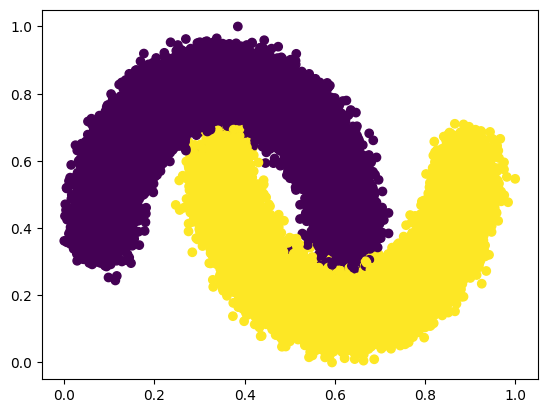

In [6]:
# Generate example data
dataset = {}
dataset_np = {}
n_training_samples = 100000
n_test_samples = 10000
train_input, train_label = make_moons(n_samples=n_training_samples, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=n_test_samples, shuffle=True, noise=0.1, random_state=None)


dataset_np['train_input'] = torch.from_numpy(train_input)
dataset_np['test_input'] = torch.from_numpy(test_input)
dataset_np['train_label'] = torch.from_numpy(train_label[:, None])
dataset_np['test_label'] = torch.from_numpy(test_label[:, None])

# Convert the data to torch.float
train_input = torch.from_numpy(train_input).float()
test_input = torch.from_numpy(test_input).float()

# Normalize the data to be between 0 and 1
train_min = train_input.min(dim=0, keepdim=True)[0]
train_max = train_input.max(dim=0, keepdim=True)[0]
test_min = test_input.min(dim=0, keepdim=True)[0]
test_max = test_input.max(dim=0, keepdim=True)[0]

train_input = (train_input - train_min) / (train_max - train_min)
test_input = (test_input - test_min) / (test_max - test_min)

dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = torch.from_numpy(train_label[:, None]).float()
dataset['test_label'] = torch.from_numpy(test_label[:, None]).float()

X_train = dataset_np['train_input']
y_train = dataset_np['train_label']
z_data_train = y_train[:, 0]
x_data_train = X_train[:, 0]
y_data_train = X_train[:, 1]

X_test = dataset_np['test_input']
y_test = dataset_np['test_label']
z_data_test = y_test[:, 0]
x_data_test = X_test[:, 0]
y_data_test = X_test[:, 1]

# Normalize x_data
x_min_train, x_max_train = x_data_train.min(), x_data_train.max()
x_data_train = (x_data_train - x_min_train) / (x_max_train - x_min_train)

# Normalize y_data
y_min_train, y_max_train = y_data_train.min(), y_data_train.max()
y_data_train = (y_data_train - y_min_train) / (y_max_train - y_min_train)

# Normalize x_data test
x_min_test, x_max_test = x_data_test.min(), x_data_test.max()
x_data_test = (x_data_test - x_min_test) / (x_max_test - x_min_test)

# Normalize y_data test
y_min_test, y_max_test = y_data_test.min(), y_data_test.max()
y_data_test = (y_data_test - y_min_test) / (y_max_test - y_min_test)

plt.scatter(x_data_train, y_data_train, c=z_data_train)

# Run Quantum Annealing

In [7]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty_categorical(
    d1=degree1, d2=degree2,
    m1=m1, m2=m2,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    x_data_train=x_data_train.tolist(),
    y_data_train=y_data_train.tolist(),
    z_data_train=z_data_train.tolist(),
    x_data_test=x_data_test.tolist(),
    y_data_test=y_data_test.tolist(),
    z_data_test=z_data_test.tolist(),
    test_multiplier=test_multiplier
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_minus1_str, coeffs_plus2_str, coeffs_minus2_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_minus1_str = [item for sublist in coeffs_minus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_minus2_str = [item for sublist in coeffs_minus2_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_minus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_minus2_str[:]
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, 2 * m1 + 1), vartype='BINARY')
coefficients_minus_1 = Array.create('coeff_minus_1', shape=(num_basis_funcs_1, 2 * m1 + 1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, 2 * m2 + 1), vartype='BINARY')
coefficients_minus_2 = Array.create('coeff_minus_2', shape=(num_basis_funcs_2, 2 * m2 + 1), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
coefficients_minus_2_np = np.array(coefficients_minus_2)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_minus_1_np, coefficients_plus_2_np, coefficients_minus_2_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
for var in enumerate(sorted(Solving_for_vars)):
    index += 1
    # print(var)
    var = str(var[1])
    parts = str(var).split('_')
    prefix = f"{parts[0]}_{parts[2]}"
    i = int(parts[1])
    j = int(parts[3])
    if prefix == 'P1_plus':
        sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
    elif prefix == 'P2_plus':
        sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
    elif prefix == 'P1_minus':
        sympy_to_pyqubo_map[f"{var}"] = coefficients_minus_1[i, j]
    elif prefix == 'P2_minus':
        sympy_to_pyqubo_map[f"{var}"] = coefficients_minus_2[i, j]

        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm)

end_time_quantum_part1 = time.perf_counter()

In [8]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.7596311409997725


Timing Information:
qpu_sampling_time: 250840.0 microseconds
qpu_anneal_time_per_sample: 20.0 microseconds
qpu_readout_time_per_sample: 84.85 microseconds
qpu_access_time: 270067.62 microseconds
qpu_access_overhead_time: 3560.38 microseconds
qpu_programming_time: 19227.62 microseconds
qpu_delay_time_per_sample: 20.57 microseconds
post_processing_overhead_time: 34.0 microseconds
total_post_processing_time: 34.0 microseconds

QPU Access Time: 270067.62 microseconds
Time spent on simulated annealer part 2: 0.27006762
Time spent on part 3: 0.0010841179991984973
Time spent on optimization: 1.030782878998971


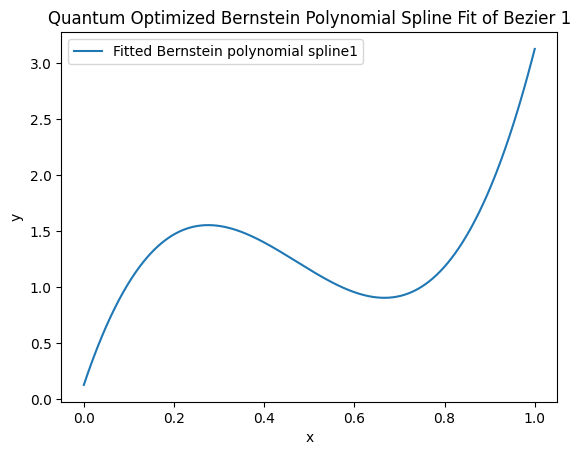

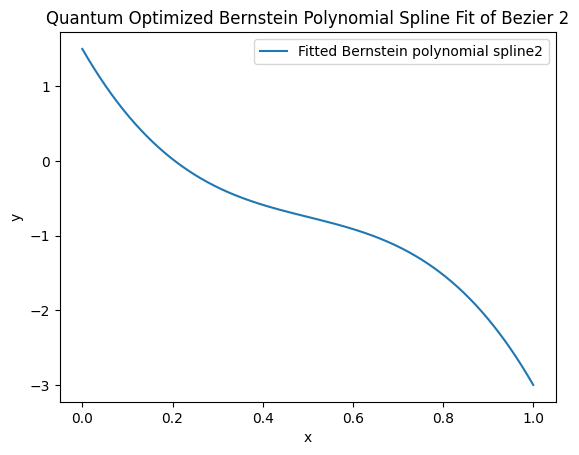

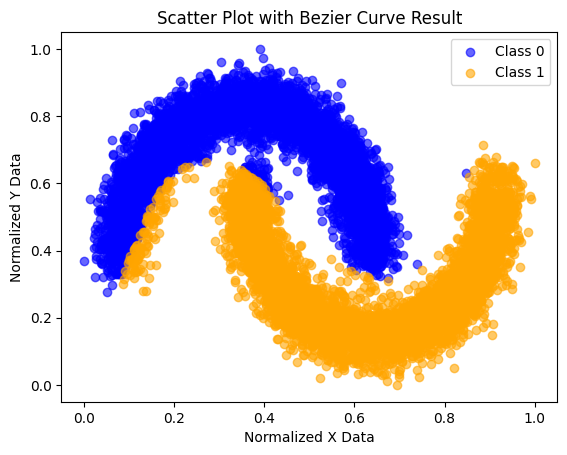

total_time_optimization: 1.030782878998971, train_f1: 0.9851216731922486, test_f1: 0.983242439266237


In [9]:
time_quantum_part2, time_quantum_part3, total_time_quantum_optimization, quantum_train_accuracy, quantum_train_precision, quantum_train_recall, quantum_train_f1, quantum_test_accuracy, quantum_test_precision, quantum_test_recall, quantum_test_f1 = run_annealing("QA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, m1, m2, degree1, degree2, x_data_train, y_data_train, z_data_train, x_data_test, y_data_test, z_data_test, dataset, num_reads=2000, annealing_time=20)

Time spent on simulated part 2: 14.58538451899949
Time spent on part 3: 0.0009829820000959444
Time spent on optimization: 15.345998641999358


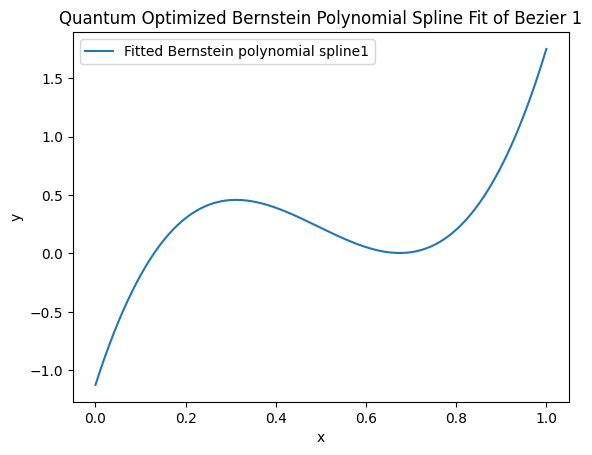

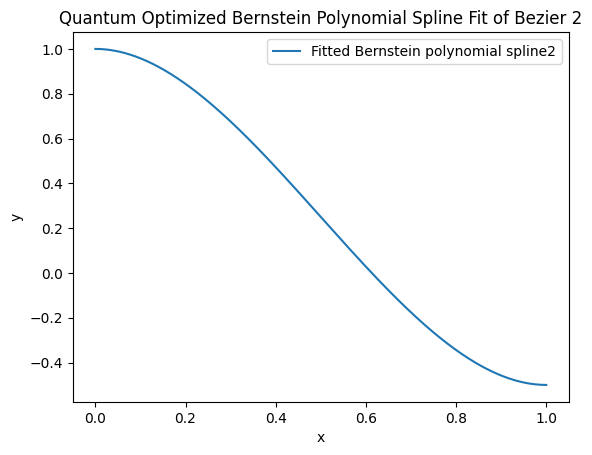

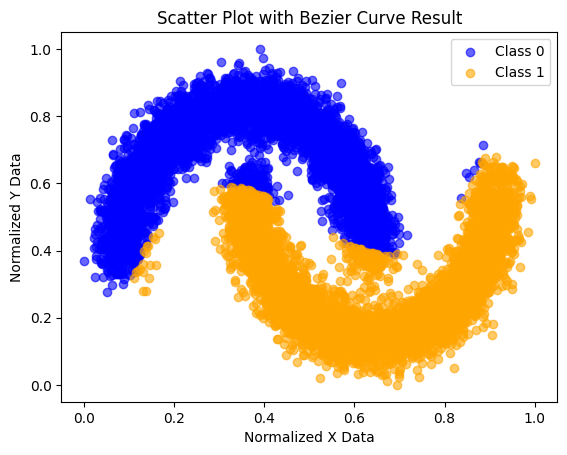

total_time_optimization: 15.345998641999358, train_f1: 0.973870739415207, test_f1: 0.9730592696068648


In [10]:
time_simulated_part2, time_simulated_part3, total_time_simulated_optimization, simulated_train_accuracy, simulated_train_precision, simulated_train_recall, simulated_train_f1, simulated_test_accuracy, simulated_test_precision, simulated_test_recall, simulated_test_f1 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, m1, m2, degree1, degree2, x_data_train, y_data_train, z_data_train, x_data_test, y_data_test, z_data_test, dataset, num_reads=3000)

description:   0%|                                                          | 0/130 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
train loss: 5.49e-01 | test loss: 5.48e-01 | reg: 2.22e+00 : 100%|█| 130/130 [00:07<00:00, 16.62it/s


Training time in seconds of lr=0.001: 7.826025401999686
Learning Rate: 0.001, Train Accuracy: 0.5, Test Accuracy: 0.5


train loss: 2.82e-01 | test loss: 2.82e-01 | reg: 2.62e+00 : 100%|█| 130/130 [00:07<00:00, 18.14it/s


Training time in seconds of lr=0.01: 7.172926195999935
Learning Rate: 0.01, Train Accuracy: 0.8924000263214111, Test Accuracy: 0.8903999924659729


train loss: 2.14e-01 | test loss: 2.14e-01 | reg: 2.71e+00 : 100%|█| 130/130 [00:06<00:00, 18.63it/s


Training time in seconds of lr=0.05: 6.982035562999954
Learning Rate: 0.05, Train Accuracy: 0.9622899889945984, Test Accuracy: 0.9591000080108643


train loss: 1.96e-01 | test loss: 2.12e-01 | reg: 2.77e+00 : 100%|█| 130/130 [00:07<00:00, 18.40it/s


Training time in seconds of lr=0.1: 7.0686905900001875
Learning Rate: 0.1, Train Accuracy: 0.9767299890518188, Test Accuracy: 0.9675999879837036


train loss: 1.95e-01 | test loss: 2.05e-01 | reg: 2.70e+00 : 100%|█| 130/130 [00:06<00:00, 18.69it/s


Training time in seconds of lr=0.2: 6.961367644999882
Learning Rate: 0.2, Train Accuracy: 0.9743199944496155, Test Accuracy: 0.9668999910354614


train loss: 2.14e-01 | test loss: 2.14e-01 | reg: 2.71e+00 : 100%|█| 130/130 [00:07<00:00, 18.41it/s


Training time in seconds of lr=0.05: 7.063817014000051
Learning Rate: 0.05, Train Accuracy: 0.9622899889945984, Test Accuracy: 0.9591000080108643


train loss: 1.96e-01 | test loss: 2.12e-01 | reg: 2.77e+00 : 100%|█| 130/130 [00:07<00:00, 18.45it/s


Training time in seconds of lr=0.1: 7.052656740999737
Learning Rate: 0.1, Train Accuracy: 0.9767299890518188, Test Accuracy: 0.9675999879837036


train loss: 1.95e-01 | test loss: 2.05e-01 | reg: 2.70e+00 : 100%|█| 130/130 [00:07<00:00, 18.57it/s


Training time in seconds of lr=0.2: 7.006695330999719
Learning Rate: 0.2, Train Accuracy: 0.9743199944496155, Test Accuracy: 0.9668999910354614


train loss: 1.94e-01 | test loss: 2.07e-01 | reg: 2.44e+00 : 100%|█| 130/130 [00:06<00:00, 18.64it/s


Training time in seconds of lr=0.5: 6.979531695999867
Learning Rate: 0.5, Train Accuracy: 0.976580023765564, Test Accuracy: 0.9674999713897705


train loss: 1.95e-01 | test loss: 2.10e-01 | reg: 4.92e+00 : 100%|█| 130/130 [00:06<00:00, 18.59it/s


Training time in seconds of lr=1.0: 6.9970046329999604
Learning Rate: 1.0, Train Accuracy: 0.9794600009918213, Test Accuracy: 0.9704999923706055


train loss: 1.99e-01 | test loss: 2.06e-01 | reg: 2.60e+00 : 100%|█| 130/130 [00:07<00:00, 18.10it/s


Training time in seconds of lr=1.5: 7.186773057999744
Learning Rate: 1.5, Train Accuracy: 0.9700000286102295, Test Accuracy: 0.9631999731063843
Best Learning Rate: 1.0 with Test Accuracy: 0.9704999923706055


train loss: 1.95e-01 | test loss: 2.10e-01 | reg: 4.92e+00 : 100%|█| 130/130 [00:07<00:00, 18.40it/s


Training time in seconds of best lr which is lr=1.5: 7.070328208999854
Best Learning Rate: 1.0, Train Accuracy: 0.9794600009918213, Test Accuracy: 0.9704999923706055
Layer 0 Bezier coefficients:
[[ 0.24080727  2.9893591  -0.82584965  2.2637522 ]
 [-0.14592305 -0.41083372 -0.8220461  -1.0801932 ]]


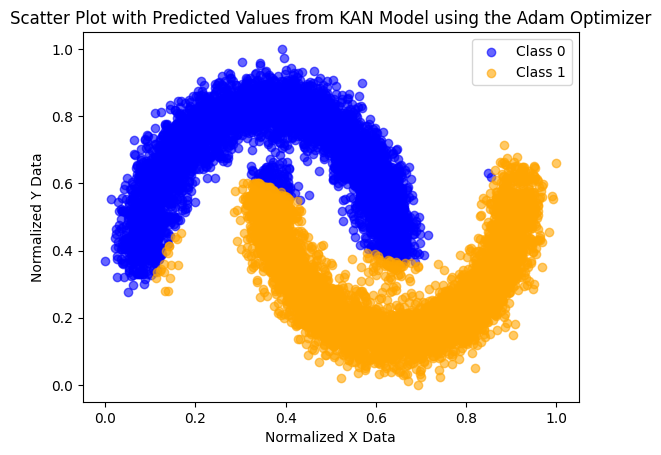

time_best_lr: 7.070328208999854, train_f1: 0.9824449218164559, test_f1: 0.9820659252579901


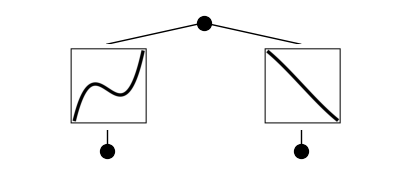

In [11]:
# Experiment with different learning rates
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.05, 0.1, 0.2, 0.5, 1.0, 1.5]
steps = 130

adam_time_best_lr, adam_train_accuracy, adam_train_precision, adam_train_recall, adam_train_f1, adam_test_accuracy, adam_test_precision, adam_test_recall, adam_test_f1 = train_classical_optimizer(dataset, degrees, "Adam", steps, learning_rates, x_data_test, y_data_test, z_data_train, z_data_test)


train loss: 6.40e-01 | test loss: 6.39e-01 | reg: 2.07e+00 : 100%|█| 180/180 [00:09<00:00, 18.24it/s


Training time in seconds of lr=0.001: 9.8725489870003
Learning Rate: 0.001, Train Accuracy: 0.5, Test Accuracy: 0.5


train loss: 3.78e-01 | test loss: 3.75e-01 | reg: 2.44e+00 : 100%|█| 180/180 [00:09<00:00, 18.93it/s


Training time in seconds of lr=0.01: 9.510835753999345
Learning Rate: 0.01, Train Accuracy: 0.8623300194740295, Test Accuracy: 0.862500011920929


train loss: 2.88e-01 | test loss: 2.88e-01 | reg: 2.52e+00 : 100%|█| 180/180 [00:10<00:00, 17.66it/s


Training time in seconds of lr=0.05: 10.196331224999994
Learning Rate: 0.05, Train Accuracy: 0.8833100199699402, Test Accuracy: 0.8830999732017517


train loss: 2.79e-01 | test loss: 2.78e-01 | reg: 2.52e+00 : 100%|█| 180/180 [00:10<00:00, 17.32it/s


Training time in seconds of lr=0.1: 10.400457734000156
Learning Rate: 0.1, Train Accuracy: 0.8932999968528748, Test Accuracy: 0.892300009727478


train loss: 2.60e-01 | test loss: 2.59e-01 | reg: 2.55e+00 : 100%|█| 180/180 [00:09<00:00, 18.46it/s


Training time in seconds of lr=0.2: 9.756230877000235
Learning Rate: 0.2, Train Accuracy: 0.910099983215332, Test Accuracy: 0.9089999794960022


train loss: 2.88e-01 | test loss: 2.88e-01 | reg: 2.52e+00 : 100%|█| 180/180 [00:09<00:00, 18.76it/s


Training time in seconds of lr=0.05: 9.601215369000784
Learning Rate: 0.05, Train Accuracy: 0.8833100199699402, Test Accuracy: 0.8830999732017517


train loss: 2.79e-01 | test loss: 2.78e-01 | reg: 2.52e+00 : 100%|█| 180/180 [00:09<00:00, 18.73it/s


Training time in seconds of lr=0.1: 9.614488874999552
Learning Rate: 0.1, Train Accuracy: 0.8932999968528748, Test Accuracy: 0.892300009727478


train loss: 2.60e-01 | test loss: 2.59e-01 | reg: 2.55e+00 : 100%|█| 180/180 [00:09<00:00, 18.34it/s


Training time in seconds of lr=0.2: 9.820815428999595
Learning Rate: 0.2, Train Accuracy: 0.910099983215332, Test Accuracy: 0.9089999794960022


train loss: 2.06e-01 | test loss: 2.08e-01 | reg: 2.64e+00 : 100%|█| 180/180 [00:09<00:00, 18.88it/s


Training time in seconds of lr=0.5: 9.536823035999987
Learning Rate: 0.5, Train Accuracy: 0.9599199891090393, Test Accuracy: 0.957099974155426


train loss: 1.95e-01 | test loss: 2.05e-01 | reg: 2.73e+00 : 100%|█| 180/180 [00:09<00:00, 19.06it/s


Training time in seconds of lr=1.0: 9.445864059999622
Learning Rate: 1.0, Train Accuracy: 0.9724699854850769, Test Accuracy: 0.9656000137329102


train loss: 2.44e-01 | test loss: 2.49e-01 | reg: 2.66e+00 : 100%|█| 180/180 [00:09<00:00, 18.74it/s


Training time in seconds of lr=1.5: 9.607712304000415
Learning Rate: 1.5, Train Accuracy: 0.952269971370697, Test Accuracy: 0.9537000060081482
Best Learning Rate: 1.0 with Test Accuracy: 0.9656000137329102


train loss: 1.96e-01 | test loss: 2.04e-01 | reg: 2.72e+00 : 100%|█| 180/180 [00:09<00:00, 18.52it/s


Training time in seconds of best lr which is lr=1.5: 9.72661879899988
Best Learning Rate: 1.0, Train Accuracy: 0.9721199870109558, Test Accuracy: 0.9659000039100647
Layer 0 Bezier coefficients:
[[-0.5343169   1.6102974  -1.3403962   1.0703409 ]
 [ 0.9277904   0.7739467  -0.49717966 -0.5821136 ]]


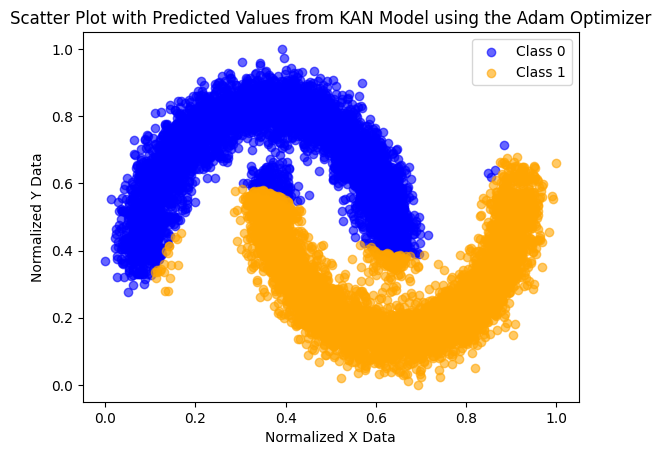

time_best_lr: 9.72661879899988, train_f1: 0.9739078276517045, test_f1: 0.9731785428342674


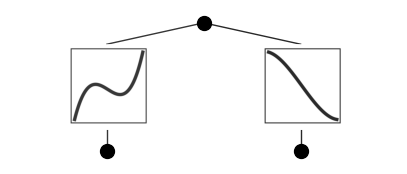

In [12]:
sgd_steps = 180
sgd_time_best_lr, sgd_train_accuracy, sgd_train_precision, sgd_train_recall, sgd_train_f1, sgd_test_accuracy, sgd_test_precision, sgd_test_recall, sgd_test_f1 = train_classical_optimizer(dataset, degrees, "SGD", sgd_steps, learning_rates, x_data_test, y_data_test, z_data_train, z_data_test)

train loss: 6.73e-01 | test loss: 6.73e-01 | reg: 2.01e+00 : 100%|█| 160/160 [00:08<00:00, 18.23it/s


Training time in seconds of lr=0.001: 8.782004787000005
Learning Rate: 0.001, Train Accuracy: 0.5, Test Accuracy: 0.5


train loss: 4.32e-01 | test loss: 4.29e-01 | reg: 2.33e+00 : 100%|█| 160/160 [00:08<00:00, 18.57it/s


Training time in seconds of lr=0.01: 8.621730337999907
Learning Rate: 0.01, Train Accuracy: 0.7118600010871887, Test Accuracy: 0.7242000102996826


train loss: 2.76e-01 | test loss: 2.75e-01 | reg: 2.65e+00 : 100%|█| 160/160 [00:08<00:00, 18.52it/s


Training time in seconds of lr=0.05: 8.645554390000143
Learning Rate: 0.05, Train Accuracy: 0.8972499966621399, Test Accuracy: 0.894599974155426


train loss: 2.30e-01 | test loss: 2.28e-01 | reg: 2.72e+00 : 100%|█| 160/160 [00:08<00:00, 18.60it/s


Training time in seconds of lr=0.1: 8.607547108999825
Learning Rate: 0.1, Train Accuracy: 0.9372900128364563, Test Accuracy: 0.9366000294685364


train loss: 1.97e-01 | test loss: 2.04e-01 | reg: 2.81e+00 : 100%|█| 160/160 [00:08<00:00, 18.34it/s


Training time in seconds of lr=0.2: 8.726728036999702
Learning Rate: 0.2, Train Accuracy: 0.9708600044250488, Test Accuracy: 0.9639000296592712


train loss: 2.76e-01 | test loss: 2.75e-01 | reg: 2.65e+00 : 100%|█| 160/160 [00:08<00:00, 18.76it/s


Training time in seconds of lr=0.05: 8.535507343000063
Learning Rate: 0.05, Train Accuracy: 0.8972499966621399, Test Accuracy: 0.894599974155426


train loss: 2.30e-01 | test loss: 2.28e-01 | reg: 2.72e+00 : 100%|█| 160/160 [00:08<00:00, 18.84it/s


Training time in seconds of lr=0.1: 8.497746021999774
Learning Rate: 0.1, Train Accuracy: 0.9372900128364563, Test Accuracy: 0.9366000294685364


train loss: 1.97e-01 | test loss: 2.04e-01 | reg: 2.81e+00 : 100%|█| 160/160 [00:08<00:00, 18.77it/s


Training time in seconds of lr=0.2: 8.528772603999641
Learning Rate: 0.2, Train Accuracy: 0.9708600044250488, Test Accuracy: 0.9639000296592712


train loss: 1.97e-01 | test loss: 2.04e-01 | reg: 2.80e+00 : 100%|█| 160/160 [00:08<00:00, 18.84it/s


Training time in seconds of lr=0.5: 8.496291538999685
Learning Rate: 0.5, Train Accuracy: 0.9710299968719482, Test Accuracy: 0.9657999873161316


train loss: 2.23e-01 | test loss: 2.23e-01 | reg: 2.87e+00 : 100%|█| 160/160 [00:08<00:00, 18.48it/s


Training time in seconds of lr=1.0: 8.66180833999988
Learning Rate: 1.0, Train Accuracy: 0.9456599950790405, Test Accuracy: 0.944599986076355


train loss: 2.55e-01 | test loss: 2.54e-01 | reg: 4.43e+00 : 100%|█| 160/160 [00:08<00:00, 18.61it/s


Training time in seconds of lr=1.5: 8.603353686000446
Learning Rate: 1.5, Train Accuracy: 0.9157099723815918, Test Accuracy: 0.9146999716758728
Best Learning Rate: 0.5 with Test Accuracy: 0.9657999873161316


train loss: 1.97e-01 | test loss: 2.04e-01 | reg: 2.80e+00 : 100%|█| 160/160 [00:08<00:00, 18.76it/s


Training time in seconds of best lr which is lr=1.5: 8.534219618999487
Best Learning Rate: 0.5, Train Accuracy: 0.9711999893188477, Test Accuracy: 0.9660000205039978
Layer 0 Bezier coefficients:
[[-0.36897337  1.3878511  -1.0154592   0.955593  ]
 [ 0.9406083   0.65734303 -0.6375526  -0.8753221 ]]


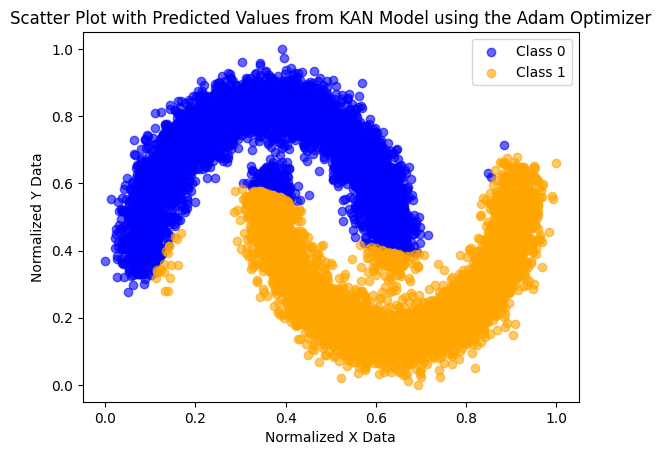

time_best_lr: 8.534219618999487, train_f1: 0.9725650892009395, test_f1: 0.9715943188637729


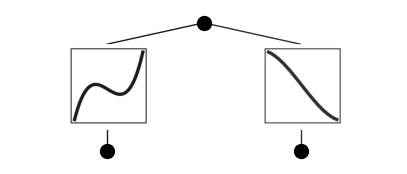

In [13]:
adagrad_steps = 160
adagrad_time_best_lr, adagrad_train_accuracy, adagrad_train_precision, adagrad_train_recall, adagrad_train_f1, adagrad_test_accuracy, adagrad_test_precision, adagrad_test_recall, adagrad_test_f1 = train_classical_optimizer(dataset, degrees, "AdaGrad", adagrad_steps, learning_rates, x_data_test, y_data_test, z_data_train, z_data_test)

# Now lets look at the metrics for all models

In [14]:
print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {total_time_quantum_optimization}")
print(f"Training Accuracy: {quantum_train_accuracy:.4f}, Train Precision: {quantum_train_precision:.4f}, Train Recall: {quantum_train_recall:.4f}, Train F1: {quantum_train_f1:.4f}")
print(f"Test Accuracy: {quantum_test_accuracy:.4f}, Test Precision: {quantum_test_precision:.4f}, Test Recall: {quantum_test_recall:.4f}, Test F1: {quantum_test_f1:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {total_time_simulated_optimization}")
print(f"Training Accuracy: {simulated_train_accuracy:.4f}, Train Precision: {simulated_train_precision:.4f}, Train Recall: {simulated_train_recall:.4f}, Train F1: {simulated_train_f1:.4f}")
print(f"Test Accuracy: {simulated_test_accuracy:.4f}, Test Precision: {simulated_test_precision:.4f}, Test Recall: {simulated_test_recall:.4f}, Test F1: {simulated_test_f1:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {adam_time_best_lr}")
print(f"Training Accuracy: {adam_train_accuracy:.4f}, Train Precision: {adam_train_precision:.4f}, Train Recall: {adam_train_recall:.4f}, Train F1: {adam_train_f1:.4f}")
print(f"Test Accuracy: {adam_test_accuracy:.4f}, Test Precision: {adam_test_precision:.4f}, Test Recall: {adam_test_recall:.4f}, Test F1: {adam_test_f1:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {sgd_time_best_lr}")
print(f"Training Accuracy: {sgd_train_accuracy:.4f}, Train Precision: {sgd_train_precision:.4f}, Train Recall: {sgd_train_recall:.4f}, Train F1: {sgd_train_f1:.4f}")
print(f"Test Accuracy: {sgd_test_accuracy:.4f}, Test Precision: {sgd_test_precision:.4f}, Test Recall: {sgd_test_recall:.4f}, Test F1: {sgd_test_f1:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {adagrad_time_best_lr}")
print(f"Training Accuracy: {adagrad_train_accuracy:.4f}, Train Precision: {adagrad_train_precision:.4f}, Train Recall: {adagrad_train_recall:.4f}, Train F1: {adagrad_train_f1:.4f}")
print(f"Test Accuracy: {adagrad_test_accuracy:.4f}, Test Precision: {adagrad_test_precision:.4f}, Test Recall: {adagrad_test_recall:.4f}, Test F1: {adagrad_test_f1:.4f}")

Quantum Annealing Metrics:
Total run time in seconds: 1.030782878998971
Training Accuracy: 0.9850, Train Precision: 0.9766, Train Recall: 0.9938, Train F1: 0.9851
Test Accuracy: 0.9831, Test Precision: 0.9750, Test Recall: 0.9916, Test F1: 0.9832
Simulated Annealing Metrics
Total run time in seconds: 15.345998641999358
Training Accuracy: 0.9738, Train Precision: 0.9709, Train Recall: 0.9769, Train F1: 0.9739
Test Accuracy: 0.9730, Test Precision: 0.9709, Test Recall: 0.9752, Test F1: 0.9731
Adam Optimizer Metrics
Total run time in seconds: 7.070328208999854
Training Accuracy: 0.9824, Train Precision: 0.9816, Train Recall: 0.9833, Train F1: 0.9824
Test Accuracy: 0.9821, Test Precision: 0.9839, Test Recall: 0.9802, Test F1: 0.9821
SGD Optimizer Metrics
Total run time in seconds: 9.72661879899988
Training Accuracy: 0.9739, Train Precision: 0.9736, Train Recall: 0.9742, Train F1: 0.9739
Test Accuracy: 0.9732, Test Precision: 0.9740, Test Recall: 0.9724, Test F1: 0.9732
AdaGrad Optimizer Me

In [15]:
import pandas as pd 
# Create pandas DataFrames
train_df = pd.DataFrame(train_input, columns=['Feature_1', 'Feature_2'])
train_df['Label'] = train_label
test_df = pd.DataFrame(test_input, columns=['Feature_1', 'Feature_2'])
test_df['Label'] = test_label

# Save the datasets
train_df.to_csv('moon_tr100000_te10000_1thread_train_dataset.csv', index=False)
test_df.to_csv('moon_tr100000_te10000_1thread_test_dataset.csv', index=False)